# COMP90086 Workshop 11

In this workshop, you will have some practice on image segmentation.

Table of Contents

- Pixel Clustering
  - K-means
  - Mean shift

- Superpixel oversegmentation

- Graph-based segmentation
  - Region merging
  - Normalized cuts

- CNN-based segmentation
  - Semantic segmentation
  - Instance segmentation
  
- Exercises

In [8]:
## For colab user, run

! pip install pixellib
! pip install scikit-image==0.21.0


## After the update, You must restart the runtime in order to use newly installed versions.

  Using cached scikit_image-0.19.3-cp37-cp37m-macosx_10_13_x86_64.whl (13.2 MB)
ERROR: Ignored the following versions that require a different python version: 0.20.0 Requires-Python >=3.8; 0.20.0rc2 Requires-Python >=3.8; 0.20.0rc3 Requires-Python >=3.8; 0.20.0rc4 Requires-Python >=3.8; 0.20.0rc5 Requires-Python >=3.8; 0.20.0rc6 Requires-Python >=3.8; 0.20.0rc7 Requires-Python >=3.8; 0.20.0rc8 Requires-Python >=3.8; 0.21.0 Requires-Python >=3.8; 0.21.0rc0 Requires-Python >=3.8; 0.21.0rc1 Requires-Python >=3.8; 0.22.0 Requires-Python >=3.9; 0.22.0rc1 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement scikit-image==0.21.0 (from versions: 0.7.2, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.9.3, 0.10.0, 0.10.1, 0.11.2, 0.11.3, 0.12.0, 0.12.1, 0.12.2, 0.12.3, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.14.2, 0.14.3, 0.14.4, 0.14.5, 0.15.0, 0.16.1, 0.16.2, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.18.2, 0.18.3, 0.19.0rc0, 0.19.0, 0.19.1, 0.19.2, 0.19.3)
ERROR: No matching distributio

## Importing the libraries

In [4]:
## For colab user, run##
import os
import fileinput

# Define the path to the file that needs to be modified
FILE_PATH = "/usr/local/lib/python3.10/dist-packages/pixellib/semantic/deeplab.py"

# Define the old and new strings that need to be replaced
OLD_STRING = "tensorflow.python.keras"
NEW_STRING = "tensorflow.keras"

# Use fileinput to replace the old string with the new string in the file
for line in fileinput.input(FILE_PATH, inplace=True):
    print(line.replace(OLD_STRING, NEW_STRING), end='')

# Define the old and new strings that need to be replaced
# This handles model loading errors
OLD_STRING = "tensorflow.keras.utils.layer_utils import get_source_inputs"
NEW_STRING = "tensorflow.python.keras.utils.layer_utils import get_source_inputs"

# Use fileinput to replace the old string with the new string in the file
for line in fileinput.input(FILE_PATH, inplace=True):
    print(line.replace(OLD_STRING, NEW_STRING), end='')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/pixellib/semantic/deeplab.py' -> '/usr/local/lib/python3.10/dist-packages/pixellib/semantic/deeplab.py.bak'

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import logging

# Control the logging verbosity
# Suppress verbose Tensorflow logging
tf.get_logger().setLevel(logging.ERROR)
# Sets the AutoGraph verbosity level.
tf.autograph.set_verbosity(0)
# Verbosity is now 0

from sklearn.cluster import KMeans
from skimage.data import astronaut, coffee
from skimage.color import rgb2gray, label2rgb
from skimage.filters import sobel
from skimage import graph
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
plt.rcParams['figure.figsize'] = (18, 10)

In [6]:
import skimage
print(skimage.__version__)

0.19.2


## 1 Pixel Clustering

This very simple approach to segmentation just involves clustering pixels into K clusters based on their RGB colour value.

There are many different approaches in the field of image segmentation using pixel clustering, such as k-means, agglomerative, and mean-shift. We are going to discuss a popular method, the K-Means Clustering.

K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. A cluster refers to a collection of data points aggregated together because of certain similarities. The diagram below illustrates the process. 

<center>K-Means</center>
<img style="float: ;" src="https://miro.medium.com/max/1000/1*IzMqJo3MkZO6M38e709XqA.gif" width=400 height=300>
<center>(Image courtesy: Cierra Andaur)</center>

You can also [interact with and visualise the process of K-Means Algorithm here](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/).

For image segmentation, the clusters here are the different image colors. A practical application might be in the analysis of satellite images. For example, we might want to measure how much forest or desert there is in an area.

To implement K-Means in Python, we use the built-in [KMeans( ) function from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), and specify the number of clusters via the parameter `n_clusters = int (the number of clusters)`.

### (1) Load an image and check the shape

Image shape: (800, 640, 3)


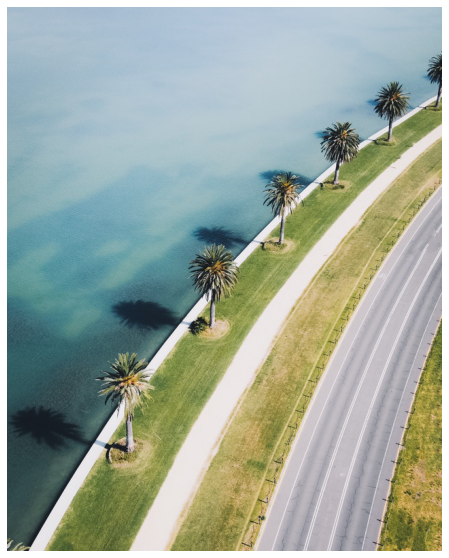

In [ ]:
# Read an image into BGR Format
img =  cv2.imread('Albert_Park.jpg')
# Convert to RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

print("Image shape:", img.shape)

plt.imshow(img) # as RGB Format
plt.axis("off")
plt.show()

### (2) Convert a 3D image into a 2D matrix
The kmeans( ) function takes a 2D array as input. Whereas our original image is 3D (width, height and channels), we need to flatten the height and width into a single vector of pixels (3 color values).

In [8]:
# Reshape the image to a 2D array of pixels and 3 color values
flat_image = img.reshape((-1,3))
# Convert to float
flat_image = np.float32(flat_image)
print(flat_image.shape)

(512000, 3)


In [9]:
800*640

512000

### (3) K-Means Clustering

In [10]:
K = 4
kmeans = KMeans(n_clusters=K)
kmeans.fit(flat_image)

KMeans(n_clusters=4)

In [11]:
kmeans.cluster_centers_

array([[189.73904 , 198.9808  , 204.77824 ],
       [159.27428 , 154.9967  ,  88.60368 ],
       [ 60.416756,  83.48019 ,  75.9657  ],
       [127.395996, 163.38275 , 171.96927 ]], dtype=float32)

In [12]:
# Convert to Integer format
centers = np.uint8(kmeans.cluster_centers_)
print(centers) # In RGB Format

[[189 198 204]
 [159 154  88]
 [ 60  83  75]
 [127 163 171]]


Plot what colours these centres are

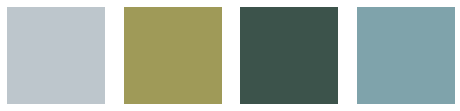

In [13]:
plt.figure(0,figsize=(8,2))

i = 1
for each_col in centers:
    plt.subplot(1,4,i)
    plt.axis("off")
    i+=1
    
    # Color Swatch
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = each_col
    plt.imshow(a)
    
plt.show()

### (4) Segmentation of the original image (K=4) 

In [14]:
res = centers[kmeans.labels_]
result_image1 = res.reshape((img.shape))

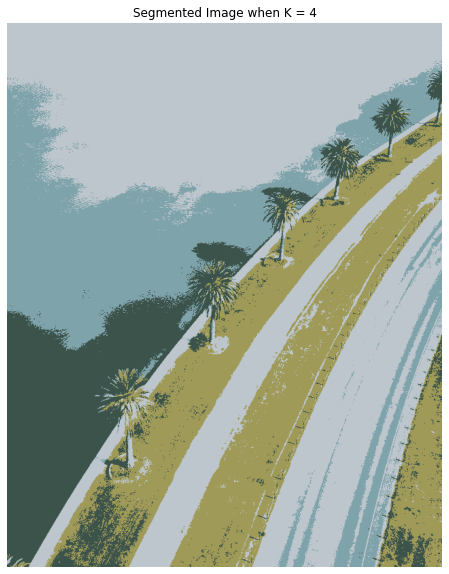

In [15]:
plt.imshow(result_image1)
plt.title("Segmented Image when K = 4")
plt.axis("off")
plt.show()

### (5) Segmentation of the original image with different K

In [16]:
# Use different K

# image 2
K = 10
kmeans = KMeans(n_clusters=K)
kmeans.fit(flat_image)
centers = np.uint8(kmeans.cluster_centers_)
res = centers[kmeans.labels_]
result_image2 = res.reshape((img.shape))

# image 3
K = 2
kmeans = KMeans(n_clusters=K)
kmeans.fit(flat_image)
centers = np.uint8(kmeans.cluster_centers_)
res = centers[kmeans.labels_]
result_image3 = res.reshape((img.shape))

In [ ]:
# Expected result of using different K?
# Downsides with this approach?

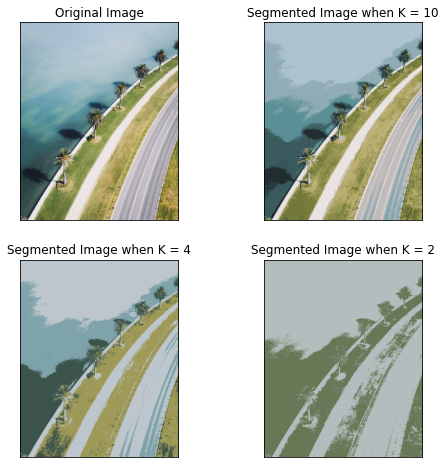

In [17]:
# Plot them out
figure_size = 8
plt.figure(figsize=(figure_size,figure_size))
#original image
plt.subplot(2,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#image 2
plt.subplot(2,2,2),plt.imshow(result_image2)
plt.title('Segmented Image when K = 10'), plt.xticks([]), plt.yticks([])
#image 1
plt.subplot(2,2,3),plt.imshow(result_image1)
plt.title('Segmented Image when K = 4'), plt.xticks([]), plt.yticks([])
#image 3
plt.subplot(2,2,4),plt.imshow(result_image3)
plt.title('Segmented Image when K = 2'), plt.xticks([]), plt.yticks([])
plt.show()

For a more complicated image, the algorithm will need more clusters to pick out the details you want. The number of clusters will depend on how much detail you need to pick out.

### Exercise 1 
Implement Pixel Clustering using the Mean-Shift Clustering Algorithm.

[Mean-shift clustering](https://scikit-learn.org/stable/modules/clustering.html#mean-shift) aims to discover “blobs” in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

Different from the K-Means clustering algorithm, mean-shift does not require specifying  the number of clusters in advance. The number of clusters will be determined by algorithm for the data.

It can be implemented via the built-in [MeanShift( ) function from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html).

## Resource for understanding mean-shift algorithm: https://www.youtube.com/watch?v=PCNz_zttmtA&ab_channel=FirstPrinciplesofComputerVision

libpng warning: iCCP: known incorrect sRGB profile


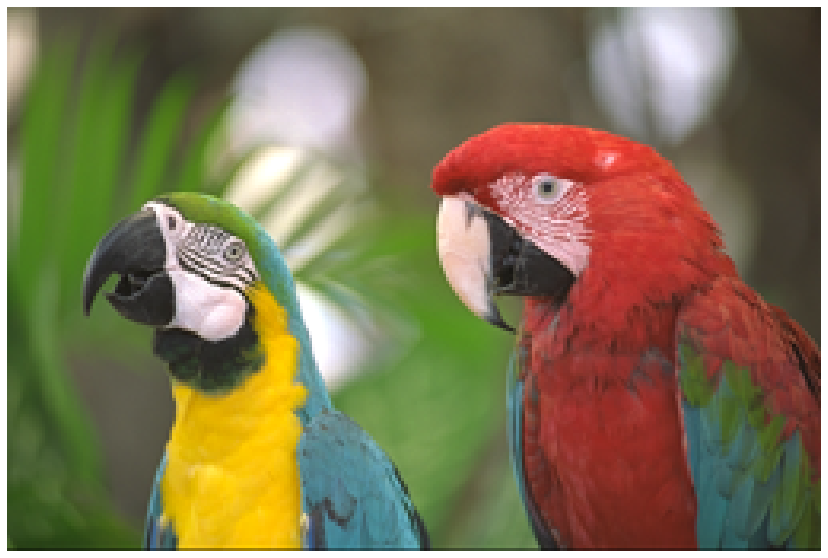

(43776, 5)


In [18]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Read an image into BGR Format
img =  cv2.imread('256kodim23.png')
# Convert to RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(img)
plt.axis("off")
plt.show()

# Reshape the image to a 2D array of pixels and 3 color values
flat_image = img.reshape((-1,3))
# Convert to float
flat_image = np.float32(flat_image)

# Get x,y coordinate values of pixels
x, y = np.meshgrid(np.arange(img.shape[0]),np.arange(img.shape[1]))
x = x.reshape((-1,1))
y = y.reshape((-1,1))
xy = np.concatenate((x,y),axis=1)

# Since the sklearn function only allows one value for bandwidth, we will scale
# the (x,y) values relative to the colour values. This has the same effect as
# using different bandwidth values for space and colour.
xy_scaling = 0.005
xy = xy_scaling*xy

# Combine colour and x,y values
flat_image = np.concatenate((flat_image,xy),axis=1)

print(flat_image.shape)

In [16]:
img =  cv2.imread('256kodim23.png')
# Convert to RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img.shape

libpng warning: iCCP: known incorrect sRGB profile


(171, 256, 3)

## Why x,y scaling?

In [ ]:
# Compute clustering with MeanShift
# your code

# Segmentation of the original image
# your code

# Plot result
# your code

In [20]:
# Estimate the bandwidth to use with the mean-shift algorithm.
bandwidth = estimate_bandwidth(flat_image, 
                                 quantile=.04, 
                                 n_jobs=-1, #use all processors your computer has
                                 n_samples=500) #The number of samples to use. Set a small value to reduce the time

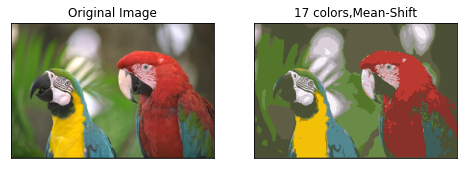

In [21]:
bandwidth = 25

# Compute clustering with MeanShift
ms = MeanShift(bandwidth = bandwidth, 
               n_jobs=-1,  #use all processors which your computer has
               bin_seeding=True, #True to speed up the algorithm because fewer seeds will be initialized
               cluster_all=True) #If true, then all points are clustered.
ms.fit(flat_image)

# Segmentation of the original image
centers = np.uint8(ms.cluster_centers_) # Convert centers to Integer format
res = centers[ms.labels_]
res = res[:,:3] # For visualisation, take just the color values (first 3 columns)
result_image = res.reshape((img.shape))

# Plot result
figure_size = 8
plt.figure(figsize=(figure_size,figure_size))
# original image
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# final image
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title(str(len(ms.cluster_centers_))+" colors,Mean-Shift"), plt.xticks([]), plt.yticks([])
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

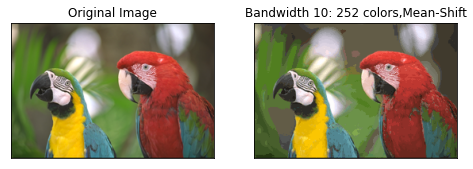

 11%|█         | 1/9 [00:32<04:21, 32.64s/it]

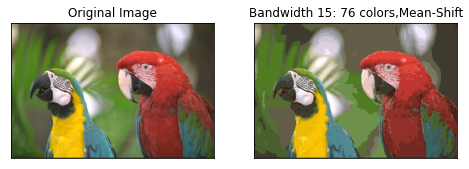

 22%|██▏       | 2/9 [00:44<02:21, 20.17s/it]

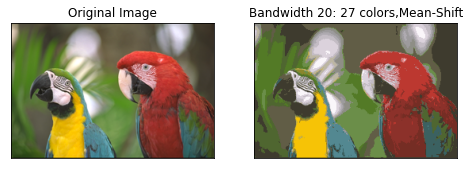

 33%|███▎      | 3/9 [00:49<01:21, 13.62s/it]

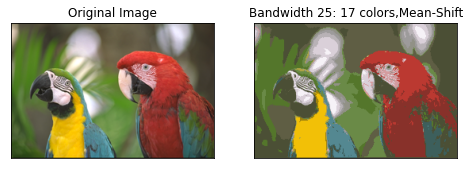

 44%|████▍     | 4/9 [00:53<00:48,  9.76s/it]

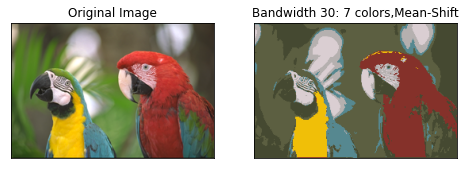

 56%|█████▌    | 5/9 [00:56<00:29,  7.31s/it]

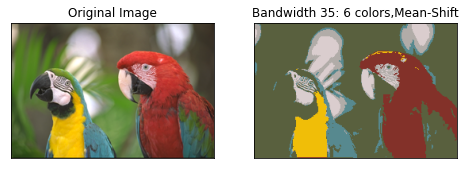

 67%|██████▋   | 6/9 [00:58<00:16,  5.50s/it]

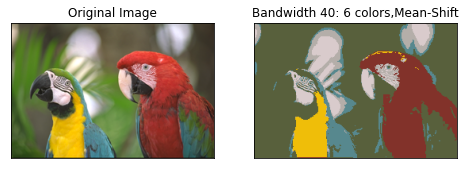

 78%|███████▊  | 7/9 [01:00<00:08,  4.33s/it]

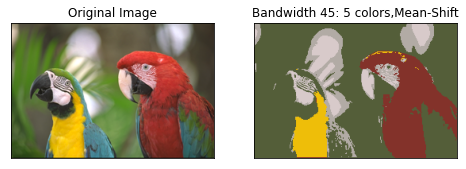

 89%|████████▉ | 8/9 [01:02<00:03,  3.56s/it]

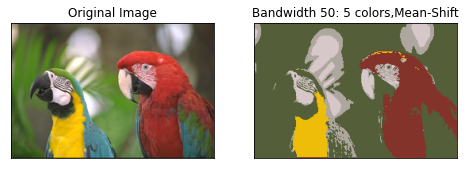

100%|██████████| 9/9 [01:04<00:00,  7.13s/it]


In [24]:
bandwidth_values = range(10, 51,5) # 10 to 50
from tqdm import tqdm 

for bandwidth in tqdm(bandwidth_values):
    
    # Compute clustering with MeanShift
    ms = MeanShift(bandwidth = bandwidth, 
                   n_jobs=-1,  #use all processors which your computer has
                   bin_seeding=True, #True to speed up the algorithm because fewer seeds will be initialized
                   cluster_all=True) #If true, then all points are clustered.
    ms.fit(flat_image)
    
    # Segmentation of the original image
    centers = np.uint8(ms.cluster_centers_) # Convert centers to Integer format
    res = centers[ms.labels_]
    res = res[:,:3] # For visualisation, take just the color values (first 3 columns)
    result_image = res.reshape((img.shape))
    
    # Plot result
    figure_size = 8
    plt.figure(figsize=(figure_size,figure_size))
    # original image
    plt.subplot(1,2,1),plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    # final image
    plt.subplot(1,2,2),plt.imshow(result_image)
    plt.title(f"Bandwidth {bandwidth}: {len(ms.cluster_centers_)} colors,Mean-Shift"), plt.xticks([]), plt.yticks([])
    plt.show()

Try different values for the xy_scaling and bandwidth parameters to see how it changes the result.

## 2 Superpixel-based Segmentation

This approach is based on over-segmenting the image (usually by simple features like colour/edges) and then merging similar regions. 


Adapted from the [Docs for scikit-image](https://scikit-image.org/docs/dev/auto_examples/)

### 2.1 Over-segmentation

This demos compares four popular low-level image segmentation methods.  As
it is difficult to obtain good segmentations, and the definition of "good"
often depends on the application, these methods are usually used for obtaining
an oversegmentation, also known as superpixels. 

#### Felzenszwalb's efficient graph based segmentation
This fast 2D image segmentation algorithm, proposed in [[1]](http://cs.brown.edu/people/pfelzens/papers/seg-ijcv.pdf) is popular in the
computer vision community.
The algorithm has a single ``scale`` parameter that influences the segment
size. The actual size and number of segments can vary greatly, depending on
local contrast.


#### Quickshift image segmentation

Quickshift is a relatively recent 2D image segmentation algorithm, based on an
approximation of kernelized mean-shift. Therefore it belongs to the family of
local mode-seeking algorithms and is applied to the 5D space consisting of
color information and image location [[2]](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/vedaldi08quick.pdf).

One of the benefits of quickshift is that it actually computes a
hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: ``sigma`` controls the scale of the local
density approximation, ``max_dist`` selects a level in the hierarchical
segmentation that is produced. There is also a trade-off between distance in
color-space and distance in image-space, given by ``ratio``.


#### SLIC - K-Means based image segmentation

This algorithm simply performs K-means in the 5d space of color information and
image location and is therefore closely related to quickshift. As the
clustering method is simpler, it is very efficient. It is essential for this
algorithm to work in Lab color space to obtain good results.  The algorithm
quickly gained momentum and is now widely used. See [[3]](https://core.ac.uk/download/pdf/147983593.pdf) for details.  The
``compactness`` parameter trades off color-similarity and proximity, as in the
case of Quickshift, while ``n_segments`` chooses the number of centers for
kmeans.


#### Compact watershed segmentation of gradient images

Instead of taking a color image as input, watershed requires a grayscale
*gradient* image, where bright pixels denote a boundary between regions.
The algorithm views the image as a landscape, with bright pixels forming high
peaks. This landscape is then flooded from the given *markers*, until separate
flood basins meet at the peaks. Each distinct basin then forms a different
image segment. [[4]](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29)

As with SLIC, there is an additional *compactness* argument that makes it
harder for markers to flood faraway pixels. This makes the watershed regions
more regularly shaped. [[5]](https://www.tu-chemnitz.de/etit/proaut/publications/cws_pSLIC_ICPR.pdf)

More information on the functions used below, see:
- [img_as_float( )](https://scikit-image.org/docs/stable/api/skimage.html#skimage.img_as_float) Convert an image to floating point format.
- [felzenszwalb( )](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb) Computes Felsenszwalb’s efficient graph based image segmentation.
- [slic( )](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic) Segments image using k-means clustering in Color-(x,y,z) space.
- [quickshift( )](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.quickshift) Segments image using quickshift clustering in Color-(x,y) space.
- [watershed( )](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) Find watershed basins in image flooded from given markers.
- [mark_boundaries( )](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries) Return image with boundaries between labeled regions highlighted.

Felzenszwalb number of segments: 194
SLIC number of segments: 196
Quickshift number of segments: 695
Watershed number of segments: 256


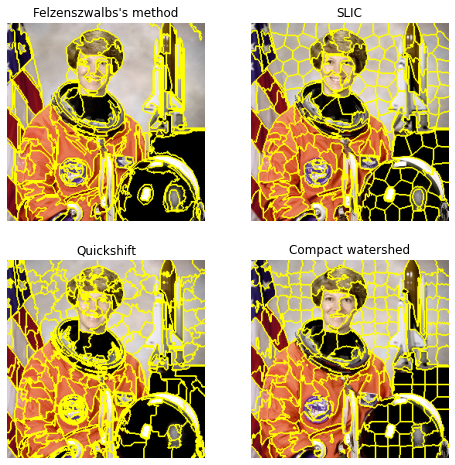

In [25]:
# Reshape the astronaut image and convert the image to floating point format.
img = img_as_float(astronaut()[::2, ::2])

# Segments image using different methods
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

# Count the number of segments
print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

# Plot them out
figure_size = 8
plt.figure(figsize=(figure_size,figure_size))
# Felzenszwalbs's method
# mark_boundaries allows us to see where we get the end of border of each segment
plt.subplot(2,2,1),plt.imshow(mark_boundaries(img, segments_fz))
plt.title("Felzenszwalbs's method"), plt.axis('off')
# SLIC
plt.subplot(2,2,2),plt.imshow(mark_boundaries(img, segments_slic))
plt.title('SLIC'), plt.axis('off')
# Quickshift
plt.subplot(2,2,3),plt.imshow(mark_boundaries(img, segments_quick))
plt.title('Quickshift'), plt.axis('off')
# Compact watershed
plt.subplot(2,2,4),plt.imshow(mark_boundaries(img, segments_watershed))
plt.title('Compact watershed'), plt.axis('off')
plt.show()

.. [1] Efficient graph-based image segmentation, Felzenszwalb, P.F. and
       Huttenlocher, D.P.  International Journal of Computer Vision, 2004
       
.. [2] Quick shift and kernel methods for mode seeking,
       Vedaldi, A. and Soatto, S.
       European Conference on Computer Vision, 2008
       
.. [3] Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi,
    Pascal Fua, and Sabine Suesstrunk, SLIC Superpixels Compared to
    State-of-the-art Superpixel Methods, TPAMI, May 2012.
    
.. [4] https://en.wikipedia.org/wiki/Watershed_%28image_processing%29

.. [5] Peer Neubert & Peter Protzel (2014). Compact Watershed and
       Preemptive SLIC: On Improving Trade-offs of Superpixel Segmentation
       Algorithms. ICPR 2014, pp 996-1001. :DOI:`10.1109/ICPR.2014.181`

## 3 Graph-based Segmentation

Many segmentation approaches treat the image pixels (or superpixels) as a graph and find an optimal segmentation by connecting or disconnecting nodes in the graph.

### 3.1 Region merging

In this section, we will discuss how to utilise the Region Adjacency Graph (RAG) for combining over-segmented regions of an image to obtain better segmentation. The following demo constructs a RAG and progressively merges regions that are similar in color. Merging two adjacent regions produces a new region with all the pixels from the merged regions. Regions are merged until no highly similar region pairs remain.

More information on the functions used below, see:
- [graph.rag_mean_color( )](https://scikit-image.org/docs/stable/api/skimage.graph.html#skimage.graph.rag_mean_color) Compute the Region Adjacency Graph using mean colors.
- [graph.merge_hierarchical( )](https://scikit-image.org/docs/stable/api/skimage.graph.html#skimage.graph.merge_hierarchical) Perform hierarchical merging of a RAG.
- [label2rgb( )](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.lab2rgb) Return an RGB image where color-coded labels are painted over the image.

In [5]:
def _weight_mean_color(g, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    g : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = g.nodes[dst]['mean color'] - g.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(g, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    g.nodes[dst]['total color'] += g.nodes[src]['total color']
    g.nodes[dst]['pixel count'] += g.nodes[src]['pixel count']
    g.nodes[dst]['mean color'] = (g.nodes[dst]['total color'] /
                                      g.nodes[dst]['pixel count'])


In [10]:
# Load the Coffee cup image
img = coffee() 

# Use the SLIC algorithm to segment the input image and obtain the region labels
labels = slic(img, compactness=30, n_segments=400, start_label=1)
# Compute the Region Adjacency Graph using mean colors.
g = graph.rag_mean_color(img, labels)
out = label2rgb(labels, img, kind='avg', bg_label=0)
out = np.uint8(out)

# Perform hierarchical merging of a RAG.
# Greedily merges the most similar pair of nodes until no edges lower than 'thresh' remain.
labels2 = graph.merge_hierarchical(labels, g, 
                                   thresh=35, #Regions connected by an edge with weight smaller than thresh are merged.
                                   rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,#This function is called before merging two nodes.
                                   weight_func=_weight_mean_color)#The function to compute the new weights of the nodes adjacent to the merged node.

# Return an RGB image where color-coded labels are painted over the image.
out2 = label2rgb(labels2, img, kind='avg', bg_label=0)
out2 = np.uint8(out2)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

AttributeError: module 'skimage.graph' has no attribute 'rag_mean_color'

### 3.2 Normalized cuts

Instead of merging regions, let's try separating regions using normalized cuts. As in the previous example, we first oversegment the image into superpixels and connect them into a Region Adjacency Graph (RAG). Then we cut the graph into regions using Normalized Cuts.

More information on the functions used below, see:
- [graph.cut_normalized( )](https://scikit-image.org/docs/stable/api/skimage.graph.html#skimage.graph.cut_normalized) Perform Normalized Graph cut on the Region Adjacency Graph.

In [11]:
img = coffee()

labels = slic(img, compactness=30, n_segments=400,
                            start_label=1)
out = label2rgb(labels, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels, mode='similarity')
labels_nc = graph.cut_normalized(labels, g)
out_nc = label2rgb(labels_nc, img, kind='avg', bg_label=0)

out = np.uint8(out)
out_nc = np.uint8(out_nc)

# Plot results
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out)
ax[1].imshow(out_nc)

for a in ax:
    a.axis('off')

plt.tight_layout()

AttributeError: module 'skimage.graph' has no attribute 'rag_mean_color'

### Exercise 2
Try different values for the threshold (thresh) in the hierarchical merge function. What is the effect of changing the merging threshold?

## 4 CNN-based segmentation

In this section, we will use PixelLib to perform semantic segmentation and instance segmentation with pretrained model.

[Pixellib](https://github.com/ayoolaolafenwa/PixelLib) is a library for performing segmentation of objects in images and videos. It supports the two major types of image segmentation:

    1.Semantic segmentation

    2.Instance segmentation

In [12]:
import pixellib

Too slow to upload files to Colab? Try to import files from Google Drive to Colab. First, you will need to mount your Google Drive in the Colab runtime environment:

`from google.colab import drive`

`drive.mount('/content/drive')`

When you run this code, you will be asked to click on a link which will take you to a page to allow permissions. Once you've given permission, you will receive a code. Copy that code, come back to your Colab notebook, paste it into the box, and press Enter.

### 4.1 Semantic segmentation

PixelLib is implemented with Deeplabv3+ framework to perform semantic segmentation. In this demo we load [the Xception model trained](https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5) on [PASCAL VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/) for Semantic Segmentation. This dataset has 20 object categories.

<center>Objects categories and their corresponding color maps of PASCAL VOC dataset</center>
<img style="float: ;" src="https://raw.githubusercontent.com/ayoolaolafenwa/PixelLib/e6af2be69d12d06e307670ba55eda309ca463a8c/Tutorials/Images/pascal.png" width=300 height=400>
<center>(Image courtesy: PixelLib)</center>

2023-10-12 21:45:31.446582: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 21:45:37.564567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Processed Image saved successfuly in your current working directory.
Processed Image saved successfully in your current working directory.


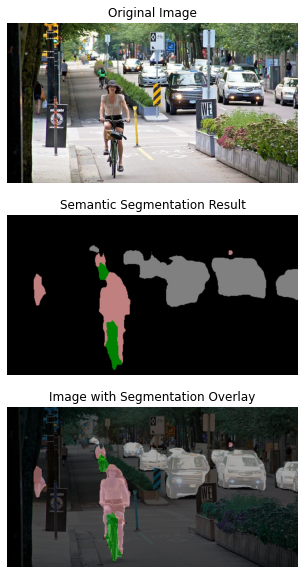

In [13]:
from pixellib.semantic import semantic_segmentation

# Created an instance of semantic segmentation class
segment_image = semantic_segmentation()

# Call the function to load the xception model trained on pascal voc.
segment_image.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5") 

# Performs segmentation on an image and the segmentation is done in the pascalvoc's color format.
segment_image.segmentAsPascalvoc("sample4.jpg", output_image_name = "output.jpg")
# Obtain an image with segmentation overlay on the objects by setting overlay = True
segment_image.segmentAsPascalvoc("sample4.jpg", output_image_name = "overlap.jpg", overlay = True)


# Display the results
# Read an image into BGR Format and Convert to RGB
img = cv2.cvtColor(cv2.imread('sample4.jpg'),cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(cv2.imread('output.jpg'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('overlap.jpg'),cv2.COLOR_BGR2RGB)
# Plot them out
plt.figure(figsize=(10,10))
plt.subplot(3,1,1),plt.imshow(img)
plt.title("Original Image"), plt.axis('off')
plt.subplot(3,1,2),plt.imshow(img1)
plt.title('Semantic Segmentation Result'), plt.axis('off')
plt.subplot(3,1,3),plt.imshow(img2)
plt.title('Image with Segmentation Overlay'), plt.axis('off')
plt.show()

### 4.2 Instance segmentation

Instance segmentation with PixelLib is based on MaskRCNN framework.

In this demo we load [the mask rcnn model trained](https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.2/mask_rcnn_coco.h5) on the [COCO dataset](https://cocodataset.org/#home) to perform instance segmentation. COCO is a dataset with 80 common object categories. The model can perform instance segmentation on these object categories. You can explore the COCO dataset by using the [COCO dataset explorer page](https://cocodataset.org/#explore).


A list of the object categories present in Coco dataset:

[‘BG’, ‘person’, ‘bicycle’, ‘car’, ‘motorcycle’, ‘airplane’, ‘bus’, ‘train’, ‘truck’, ‘boat’, ‘traffic light’, ‘fire hydrant’, ‘stop sign’, ‘parking meter’, ‘bench’, ‘bird’, ‘cat’, ‘dog’, ‘horse’, ‘sheep’, ‘cow’, ‘elephant’, ‘bear’, ‘zebra’, ‘giraffe’, ‘backpack’, ‘umbrella’, ‘handbag’, ‘tie’, ‘suitcase’, ‘frisbee’, ‘skis’, ‘snowboard’, ‘sports ball’, ‘kite’, ‘baseball bat’, ‘baseball glove’, ‘skateboard’, ‘surfboard’, ‘tennis racket’, ‘bottle’, ‘wine glass’, ‘cup’, ‘fork’, ‘knife’, ‘spoon’, ‘bowl’, ‘banana’, ‘apple’, ‘sandwich’, ‘orange’, ‘broccoli’, ‘carrot’, ‘hot dog’, ‘pizza’, ‘donut’, ‘cake’, ‘chair’, ‘couch’, ‘potted plant’, ‘bed’, ‘dining table’, ‘toilet’, ‘tv’, ‘laptop’, ‘mouse’, ‘remote’, ‘keyboard’, ‘cell phone’, ‘microwave’, ‘oven’, ‘toaster’, ‘sink’, ‘refrigerator’, ‘book’, ‘clock’, ‘vase’, ‘scissors’, ‘teddy bear’, ‘hair drier’, ‘toothbrush’]

/Users/declanwatson/opt/anaconda3/envs/CV/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Processed image saved successfully in your current working directory.
Processed Image saved successfully in your current working directory.


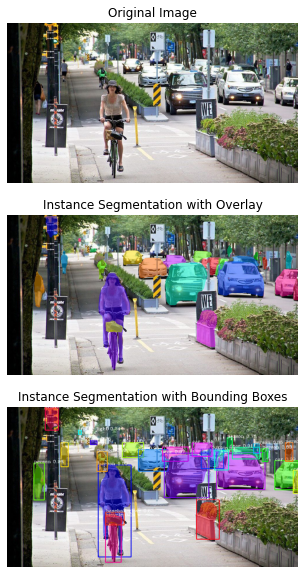

In [14]:
from pixellib.instance import instance_segmentation

# Created an instance of instance segmentation class
segment_image = instance_segmentation()

# Load the mask rcnn model to perform instance segmentation.
segment_image.load_model("mask_rcnn_coco.h5") 

# Perform instance segmentation on an image
segment_image.segmentImage("sample4.jpg", output_image_name = "img_new.jpg")
# Implement segmentation with bounding boxes.
segment_image.segmentImage("sample4.jpg", output_image_name = "img_boxes.jpg", show_bboxes = True)


# Display the results
# Read an image into BGR Format and Convert to RGB
img = cv2.cvtColor(cv2.imread('sample4.jpg'),cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(cv2.imread('img_new.jpg'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img_boxes.jpg'),cv2.COLOR_BGR2RGB)
# Plot them out
plt.figure(figsize=(10,10))
plt.subplot(3,1,1),plt.imshow(img)
plt.title("Original Image"), plt.axis('off')
plt.subplot(3,1,2),plt.imshow(img1)
plt.title('Instance Segmentation with Overlay'), plt.axis('off')
plt.subplot(3,1,3),plt.imshow(img2)
plt.title('Instance Segmentation with Bounding Boxes'), plt.axis('off')
plt.show()

The pre-trained coco model used detects 80 classes of objects. PixelLib has made it possible to filter out unused detections and detect the classes you want.

We use the function select_target_classes that determines the target class to be detected. In this case we want to detect only person in the image. In the function segmentImage we added a new parameter segment_target_classes to filter unused detections and detect only the target class.

In [15]:
# Detection of Target Classes
seg = instance_segmentation()
seg.load_model("mask_rcnn_coco.h5")
target_classes = seg.select_target_classes(person=True)
seg.segmentImage("sample4.jpg", segment_target_classes= target_classes, show_bboxes=True, output_image_name="target.jpg")

# Display the results
# Read an image into BGR Format and Convert to RGB
img = cv2.cvtColor(cv2.imread('sample4.jpg'),cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(cv2.imread('target.jpg'),cv2.COLOR_BGR2RGB)
# Plot them out
plt.figure(figsize=(15,10))
plt.subplot(1,2,1),plt.imshow(img)
plt.title("Original Image"), plt.axis('off')
plt.subplot(1,2,2),plt.imshow(img1)
plt.title('Detection of Target Classes'), plt.axis('off')
plt.show()

AttributeError: 'instance_segmentation' object has no attribute 'select_target_classes'

### Exercise 3
Try using other sample images and see the results of semantic segmentation/instance segmentation. Try to find cases where the model fails. Why do you think these cases are difficult for the classification-based approach?

- Occlusions

- Similar Objects 

- New objects

- Varied Sizes 

For more information about PixelLib, please refer to [PIXELLIB'S OFFICIAL DOCUMENTATION](https://pixellib.readthedocs.io/en/latest/index.html).

You can also implement custom training on your own dataset using PixelLib’s Library by reading this [tutorial](https://pixellib.readthedocs.io/en/latest/custom_train.html).
Or learn how how to perform inference with your custom model with PixelLib by reading this [tutorial](https://pixellib.readthedocs.io/en/latest/custom_inference.html#inference-with-a-custom-model).

### Exercise 4
(1) Explain how a segmentation approach based on meanshift clustering of colour would operate on the image shown below. What regions/objects would you expect to be segmented in the final result and why?

(2) Explain how a superpixel segmentation combined with a region-merging approach would operate on the image shown below. What regions/objects would you expect to be segmented in the final result and why?

<img style="float: ;" src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/penguins.jpg" width=600>

(1) Answer: This method would cluster pixels with similar colours together, choosing a number of clusters based on bandwidth. The final result would probably segment the ocean well but would not able to correctly segment the penguins -- the black regions would be clustered with black patches on the background and the white regions would be clustered with white regions of the background.

(2) Answer: This method would oversegment the image based on colour, then combine neighbouring regions with similar colours. The final result would probably segment the ocean well but would not able to correctly segment the penguins -- the black regions would be segmented but the white regions would be merged with the background.